In [1]:
from sklearn.datasets import load_svmlight_file
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from pathlib import Path

# Get the current working directory
current_dir = Path.cwd()

# Print it to verify
print("Current Working Directory:", current_dir)

Current Working Directory: /home/ykapil897/DAI/assign_1


In [3]:
X_train, y_train = load_svmlight_file("AnnexML/iaprtc12_train.txt", multilabel=True)
X_test, y_test = load_svmlight_file("AnnexML/iaprtc12_test.txt", multilabel=True)


In [4]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [5]:
X_train_dense.shape

(17665, 2048)

In [6]:
def save_instance_as_svm(instance, file_path, label=None):
    """
    Save a single data instance in SVM format.
    
    instance: NumPy array of shape (features,)
    file_path: Path to save the file
    label: Optional, set to 0 (dummy label) if not provided
    """
    with open(file_path, "w") as f:
        features = " ".join([f"{i+1}:{instance[i]}" for i in range(len(instance))])
        f.write(f"{label if label is not None else 0} {features}\n")  # SVM format: <label> index:value ...


In [7]:

def annexml_predict_svm(input_file, output_file="interpolated_output.txt"):
    """
    Run AnnexML prediction using subprocess.
    
    input_file: Path to the SVM-formatted input file
    output_file: Path where predictions will be saved
    """
    subprocess.run(["AnnexML/src/annexml", "predict", "AnnexML/annexml-example.json", f"predict_file={input_file}", f"result_file={output_file}", "model_file=AnnexML/iaprtc12_model.bin"], check=True)
    
    # Create an array of size 291 filled with zeros
    num_classes = 291
    predictions = np.zeros(num_classes)

    # Read predictions
    with open(output_file, "r") as f:
        prediction_str = f.read().strip()  # Assuming AnnexML outputs probabilities in a readable format
        
        # Extract content after the first tab character (\t), if present
        if "\t" in prediction_str:
            prediction_str = prediction_str.split("\t", 1)[1]  # Take everything after the first tab

        # Parse the string and fill in the array
        for pair in prediction_str.split(","):
            index, value = map(float, pair.split(":"))
            predictions[int(index)] = value

        # Normalize to make it a probability distribution
        predictions /= np.sum(predictions)
    return predictions


In [8]:
def integrated_gradients_annexml(sample_instance, baseline=None, steps=50, delta=1e-3):
    """
    Approximate Integrated Gradients for AnnexML.
    
    sample_instance: NumPy array (1D)
    baseline: Baseline input (default: zero vector)
    steps: Number of steps for approximation
    delta: Perturbation step size
    """
    global example_index
    if baseline is None:
        baseline = np.zeros_like(sample_instance)  # Default baseline: zero vector
    
    # Generate interpolated samples along the path from baseline to input
    interpolated_inputs = [baseline + (float(i) / steps) * (sample_instance - baseline) for i in range(steps + 1)]
    
    # Initialize attributions matrix (2048, 291)
    attributions = np.zeros((2048, 291))

    # Initialize DataFrame for storing predictions
    num_classes = 291
    df_columns = [str(i) for i in range(num_classes)]  # Column names as "0" to "290"
    predictions_df = pd.DataFrame(columns=df_columns)

    # First prediction (baseline)
    x_i = interpolated_inputs[0]
    save_instance_as_svm(x_i, "I_Gradients/interpolated_xi.txt")
    pred_xi = annexml_predict_svm("I_Gradients/interpolated_xi.txt", "I_Gradients/interpolated_output_xi.txt")
    
    # Convert to NumPy array and reshape to (1, 291) for DataFrame compatibility
    pred_xi = np.array(pred_xi).reshape(1, -1)
    predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_xi, columns=df_columns)], ignore_index=True)

    # Iterating over steps
    for i in range(1, steps):
        x_next = interpolated_inputs[i]
        
        # Save instances in SVM format for AnnexML
        save_instance_as_svm(x_next, "I_Gradients/interpolated_xi.txt")

        # Get predictions using AnnexML subprocess
        pred_xnext = annexml_predict_svm("I_Gradients/interpolated_xi.txt", "I_Gradients/interpolated_output_xi.txt")

        # Convert to NumPy array and reshape
        pred_xnext = np.array(pred_xnext).reshape(1, -1)
        
        # Append to DataFrame
        predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_xnext, columns=df_columns)], ignore_index=True)

        for label in range(291):
            attributions[:, label] += (pred_xnext[0, label] - pred_xi[0, label]) / (x_next - x_i + delta)
        
        pred_xi = pred_xnext
        x_i = x_next

        # Count nonzero attributions
        nonzero_count = np.count_nonzero(attributions)

        # Print the count of nonzero values
        print(f"Step {i}: Nonzero attributions count = {nonzero_count}")

    # Save DataFrame to CSV
    predictions_df.to_csv(f"I_Gradients/predictions_{example_index}.csv", index=False)
    
    example_index += 1  # Increment the example index for saving files
    # Aggregate attributions
    integrated_gradients = (sample_instance[:, np.newaxis] - baseline[:, np.newaxis]) * attributions / steps
    return integrated_gradients


In [15]:
# Usage example
sample_input = X_test_dense[0]  # Pick one test instance
example_index = 0  # Reset the example index
feature_importance = integrated_gradients_annexml(sample_input)



Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.32 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0247 sec, 24.6549 msec/sample (* 12 threads = 295.8584 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0219 sec, Aggregating: 0.0003 sec
/tmp/ipykernel_17962/2613537384.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_xi, columns=df_columns)], ignore_index=True)
Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, e

Step 1: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.51 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.2830 msec/sample (* 12 threads = 87.3957 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0047 sec, Aggregating: 0.0002 sec


Step 2: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.28 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.3549 msec/sample (* 12 threads = 100.2588 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0047 sec, Aggregating: 0.0007 sec


Step 3: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.12 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0092 sec, 9.1679 msec/sample (* 12 threads = 110.0149 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0062 sec, Aggregating: 0.0003 sec


Step 4: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.48 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0091 sec, 9.0940 msec/sample (* 12 threads = 109.1280 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0058 sec, Aggregating: 0.0003 sec


Step 5: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.20 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0086 sec, 8.5900 msec/sample (* 12 threads = 103.0798 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0056 sec, Aggregating: 0.0007 sec


Step 6: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.79 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0102 sec, 10.1981 msec/sample (* 12 threads = 122.3774 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0071 sec, Aggregating: 0.0003 sec


Step 7: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (17.37 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.8979 msec/sample (* 12 threads = 94.7742 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0055 sec, Aggregating: 0.0002 sec


Step 8: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.85 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0069 sec, 6.8781 msec/sample (* 12 threads = 82.5377 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0042 sec, Aggregating: 0.0002 sec


Step 9: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.46 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0091 sec, 9.0761 msec/sample (* 12 threads = 108.9134 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0063 sec, Aggregating: 0.0002 sec


Step 10: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.41 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0090 sec, 8.9581 msec/sample (* 12 threads = 107.4972 msec/sample)
Partitioning: 0.0042 sec, Embedding: 0.0047 sec, Aggregating: 0.0001 sec


Step 11: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.87 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.3781 msec/sample (* 12 threads = 88.5372 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0045 sec, Aggregating: 0.0004 sec


Step 12: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.29 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0948 msec/sample (* 12 threads = 97.1375 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0055 sec, Aggregating: 0.0002 sec


Step 13: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.91 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.1460 msec/sample (* 12 threads = 97.7526 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0053 sec, Aggregating: 0.0002 sec


Step 14: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.93 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.1358 msec/sample (* 12 threads = 97.6295 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0054 sec, Aggregating: 0.0004 sec


Step 15: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.89 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.1720 msec/sample (* 12 threads = 98.0644 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0050 sec, Aggregating: 0.0002 sec


Step 16: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.04 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0094 sec, 9.3861 msec/sample (* 12 threads = 112.6328 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0069 sec, Aggregating: 0.0003 sec


Step 17: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.10 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.2591 msec/sample (* 12 threads = 99.1087 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0054 sec, Aggregating: 0.0003 sec


Step 18: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.72 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.5152 msec/sample (* 12 threads = 90.1823 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0046 sec, Aggregating: 0.0004 sec


Step 19: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.60 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.4071 msec/sample (* 12 threads = 100.8854 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0056 sec, Aggregating: 0.0002 sec


Step 20: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.38 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0077 sec, 7.7000 msec/sample (* 12 threads = 92.3996 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0053 sec, Aggregating: 0.0002 sec


Step 21: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.11 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0097 sec, 9.7430 msec/sample (* 12 threads = 116.9157 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0067 sec, Aggregating: 0.0003 sec


Step 22: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.01 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0087 sec, 8.6999 msec/sample (* 12 threads = 104.3987 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0059 sec, Aggregating: 0.0003 sec


Step 23: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.92 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0085 sec, 8.4641 msec/sample (* 12 threads = 101.5692 msec/sample)
Partitioning: 0.0030 sec, Embedding: 0.0053 sec, Aggregating: 0.0002 sec


Step 24: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.86 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0080 sec, 7.9892 msec/sample (* 12 threads = 95.8700 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0049 sec, Aggregating: 0.0003 sec


Step 25: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.73 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0089 sec, 8.8570 msec/sample (* 12 threads = 106.2841 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0061 sec, Aggregating: 0.0002 sec


Step 26: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.24 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.9350 msec/sample (* 12 threads = 95.2206 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0050 sec, Aggregating: 0.0002 sec


Step 27: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.98 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.1549 msec/sample (* 12 threads = 97.8584 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0052 sec, Aggregating: 0.0002 sec


Step 28: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.16 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0089 sec, 8.9219 msec/sample (* 12 threads = 107.0623 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0059 sec, Aggregating: 0.0002 sec


Step 29: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.59 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0090 sec, 9.0489 msec/sample (* 12 threads = 108.5873 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0060 sec, Aggregating: 0.0002 sec


Step 30: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.47 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0078 sec, 7.8330 msec/sample (* 12 threads = 93.9960 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 31: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.18 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.3210 msec/sample (* 12 threads = 99.8526 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0051 sec, Aggregating: 0.0003 sec


Step 32: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.47 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.6182 msec/sample (* 12 threads = 91.4183 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0051 sec, Aggregating: 0.0001 sec


Step 33: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.15 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0089 sec, 8.8699 msec/sample (* 12 threads = 106.4386 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0058 sec, Aggregating: 0.0003 sec


Step 34: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.51 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.4109 msec/sample (* 12 threads = 100.9312 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0053 sec, Aggregating: 0.0003 sec


Step 35: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.14 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0086 sec, 8.5580 msec/sample (* 12 threads = 102.6964 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0059 sec, Aggregating: 0.0002 sec


Step 36: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.33 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0791 msec/sample (* 12 threads = 96.9486 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0052 sec, Aggregating: 0.0001 sec


Step 37: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.76 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.9300 msec/sample (* 12 threads = 95.1605 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0051 sec, Aggregating: 0.0003 sec


Step 38: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.16 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0095 sec, 9.5301 msec/sample (* 12 threads = 114.3608 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0066 sec, Aggregating: 0.0003 sec


Step 39: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.04 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.3599 msec/sample (* 12 threads = 100.3189 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0054 sec, Aggregating: 0.0002 sec


Step 40: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.32 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.3241 msec/sample (* 12 threads = 99.8898 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0052 sec, Aggregating: 0.0005 sec


Step 41: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.97 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0086 sec, 8.5540 msec/sample (* 12 threads = 102.6478 msec/sample)
Partitioning: 0.0031 sec, Embedding: 0.0051 sec, Aggregating: 0.0003 sec


Step 42: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.00 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4980 msec/sample (* 12 threads = 89.9763 msec/sample)
Partitioning: 0.0018 sec, Embedding: 0.0050 sec, Aggregating: 0.0006 sec


Step 43: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.86 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.3749 msec/sample (* 12 threads = 100.4992 msec/sample)
Partitioning: 0.0030 sec, Embedding: 0.0052 sec, Aggregating: 0.0002 sec


Step 44: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.75 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.2660 msec/sample (* 12 threads = 87.1925 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0047 sec, Aggregating: 0.0002 sec


Step 45: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.11 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.1270 msec/sample (* 12 threads = 97.5237 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0053 sec, Aggregating: 0.0002 sec


Step 46: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.03 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0085 sec, 8.5399 msec/sample (* 12 threads = 102.4790 msec/sample)
Partitioning: 0.0034 sec, Embedding: 0.0047 sec, Aggregating: 0.0004 sec


Step 47: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.05 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0521 msec/sample (* 12 threads = 96.6253 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0047 sec, Aggregating: 0.0004 sec


Step 48: Nonzero attributions count = 36864


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex...

Step 49: Nonzero attributions count = 36864


Build SearchIndex done! (14.10 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0094 sec, 9.4011 msec/sample (* 12 threads = 112.8130 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0061 sec, Aggregating: 0.0005 sec


In [20]:
# Find the column numbers with non-zero values
non_zero_columns = np.where(np.any(feature_importance != 0, axis=0))[0]

# Dictionary to store the top three rows for each non-zero column
top_three_rows_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance[:, col]
    
    # Get the indices of the top three values
    top_three_indices = np.argsort(column_values)[-3:][::-1]
    
    # Store the top three rows in the dictionary
    top_three_rows_per_column[col] = top_three_indices

# Print the results
for col, rows in top_three_rows_per_column.items():
    print(f"Column {col} top three rows with highest values: {rows}")

Column 13 top three rows with highest values: [2044 1616 1600]
Column 34 top three rows with highest values: [1880 1724 1647]
Column 42 top three rows with highest values: [1880 1724 1647]
Column 59 top three rows with highest values: [1880 1724 1647]
Column 85 top three rows with highest values: [1880 1724 1647]
Column 89 top three rows with highest values: [2044 1616 1600]
Column 101 top three rows with highest values: [1880 1724 1647]
Column 117 top three rows with highest values: [2044 1616 1600]
Column 130 top three rows with highest values: [2044 1616 1600]
Column 144 top three rows with highest values: [2044 1616 1600]
Column 162 top three rows with highest values: [2044 1616 1600]
Column 179 top three rows with highest values: [1880 1724 1647]
Column 236 top three rows with highest values: [2044 1616 1600]
Column 257 top three rows with highest values: [2044 1616 1600]
Column 269 top three rows with highest values: [1880 1724 1647]
Column 272 top three rows with highest values:

In [ ]:
# Assuming feature_importance is already defined
# feature_importance = ...

# Find the column numbers with non-zero values
non_zero_columns = np.where(np.any(feature_importance != 0, axis=0))[0]

# Dictionary to store the maximum value and its row number for each non-zero column
max_value_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance[:, col]
    
    # Find the maximum value and its row number
    max_value = np.max(column_values)
    max_row = np.argmax(column_values)
    
    # Store the maximum value and its row number in the dictionary
    max_value_per_column[col] = (max_value, max_row)

# Sort the columns in descending order based on the maximum values
sorted_columns = sorted(max_value_per_column.items(), key=lambda x: x[1][0], reverse=True)

# Print the results
print("Classes sorted in descending order based on maximum values:")
for col, (max_value, max_row) in sorted_columns:
    print(f"Class {col}: Max value = {max_value}, Feature number = {max_row}")

Classes sorted in descending order based on maximum values:
Class 34: Max value = 0.1622368202089609, Feature number = 1880
Class 272: Max value = 0.12696794625049113, Feature number = 1880
Class 101: Max value = 0.1058066218754093, Feature number = 1880
Class 42: Max value = 0.08464529750032744, Feature number = 1880
Class 287: Max value = 0.08464529750032744, Feature number = 1880
Class 59: Max value = 0.0775915227086335, Feature number = 1880
Class 85: Max value = 0.0775915227086335, Feature number = 1880
Class 269: Max value = 0.04937642354185768, Feature number = 1880
Class 179: Max value = 0.010051629078163885, Feature number = 1880
Class 13: Max value = -0.0, Feature number = 0
Class 89: Max value = -0.0, Feature number = 0
Class 117: Max value = -0.0, Feature number = 0
Class 130: Max value = -0.0, Feature number = 0
Class 144: Max value = -0.0, Feature number = 0
Class 162: Max value = -0.0, Feature number = 0
Class 236: Max value = -0.0, Feature number = 0
Class 257: Max valu

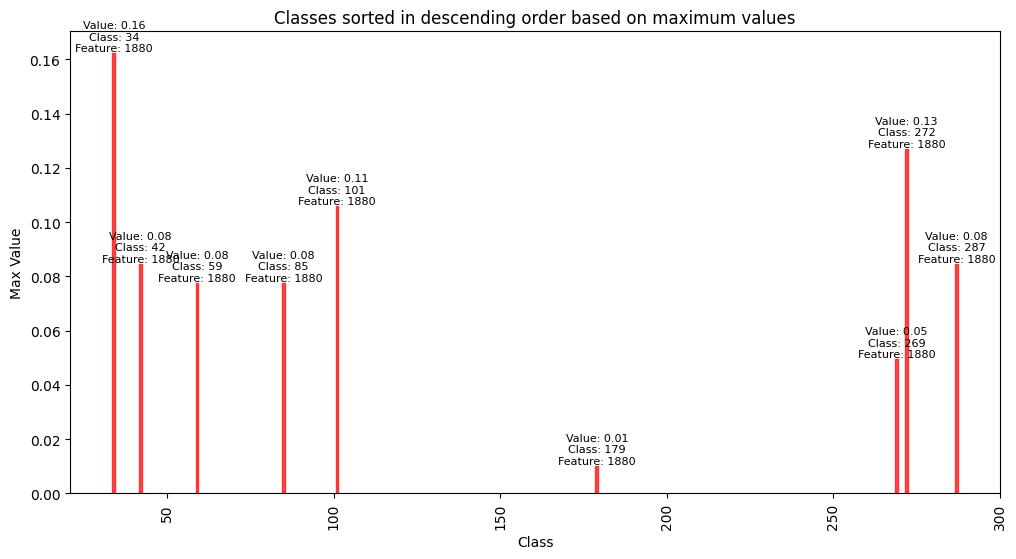

Classes sorted in descending order based on maximum values:
Class 34: Max value = 0.1622368202089609, Feature number = 1880
Class 272: Max value = 0.12696794625049113, Feature number = 1880
Class 101: Max value = 0.1058066218754093, Feature number = 1880
Class 42: Max value = 0.08464529750032744, Feature number = 1880
Class 287: Max value = 0.08464529750032744, Feature number = 1880
Class 59: Max value = 0.0775915227086335, Feature number = 1880
Class 85: Max value = 0.0775915227086335, Feature number = 1880
Class 269: Max value = 0.04937642354185768, Feature number = 1880
Class 179: Max value = 0.010051629078163885, Feature number = 1880


In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming feature_importance is already defined
# feature_importance = ...

# Find the column numbers with strictly non-zero values
non_zero_columns = np.where(np.any(feature_importance != 0, axis=0))[0]

# Dictionary to store the maximum value and its row number for each non-zero column
max_value_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance[:, col]
    
    # Find the maximum value and its row number
    max_value = np.max(column_values)
    max_row = np.argmax(column_values)
    
    # Store the maximum value and its row number in the dictionary
    if max_value != 0:
        max_value_per_column[col] = (max_value, max_row)

# Sort the columns in descending order based on the maximum values
sorted_columns = sorted(max_value_per_column.items(), key=lambda x: x[1][0], reverse=True)

# Extract the class values and corresponding feature values
classes = [col for col, _ in sorted_columns]
max_values = [max_value for _, (max_value, _) in sorted_columns]
feature_numbers = [max_row for _, (_, max_row) in sorted_columns]

# Plot the results
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, max_values, color='blue', alpha=0.7)

# Highlight the bars with non-zero values and annotate them with their values, class numbers, and feature numbers
for bar, max_value, class_num, feature_num in zip(bars, max_values, classes, feature_numbers):
    bar.set_color('red')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'Value: {max_value:.2f}\nClass: {class_num}\nFeature: {feature_num}', ha='center', va='bottom', color='black', fontsize=8)

plt.xlabel('Class')
plt.ylabel('Max Value')
plt.title('Classes sorted in descending order based on maximum values')
plt.xticks(rotation=90)
plt.show()

# Print the results
print("Classes sorted in descending order based on maximum values:")
for col, (max_value, max_row) in sorted_columns:
    print(f"Class {col}: Max value = {max_value}, Feature number = {max_row}")

In [9]:
# Usage example
sample_input_1 = X_test_dense[1]  # Pick one test instance
example_index = 1 
feature_importance_1 = integrated_gradients_annexml(sample_input_1)



Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.92 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0250 sec, 24.9770 msec/sample (* 12 threads = 299.7236 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0218 sec, Aggregating: 0.0002 sec
/tmp/ipykernel_5547/2613537384.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_xi, columns=df_columns)], ignore_index=True)
Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, em

Step 1: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.95 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.3220 msec/sample (* 12 threads = 99.8640 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0056 sec, Aggregating: 0.0001 sec


Step 2: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.20 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.2171 msec/sample (* 12 threads = 98.6052 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0051 sec, Aggregating: 0.0002 sec


Step 3: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.07 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0080 sec, 8.0221 msec/sample (* 12 threads = 96.2648 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0052 sec, Aggregating: 0.0003 sec


Step 4: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.11 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0078 sec, 7.7541 msec/sample (* 12 threads = 93.0490 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 5: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.00 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.9300 msec/sample (* 12 threads = 95.1605 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0054 sec, Aggregating: 0.0002 sec


Step 6: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.30 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.4369 msec/sample (* 12 threads = 101.2430 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0058 sec, Aggregating: 0.0002 sec


Step 7: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.90 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0562 msec/sample (* 12 threads = 96.6740 msec/sample)
Partitioning: 0.0032 sec, Embedding: 0.0046 sec, Aggregating: 0.0003 sec


Step 8: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.58 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.2052 msec/sample (* 12 threads = 98.4621 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0052 sec, Aggregating: 0.0002 sec


Step 9: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.97 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0070 sec, 7.0372 msec/sample (* 12 threads = 84.4460 msec/sample)
Partitioning: 0.0019 sec, Embedding: 0.0049 sec, Aggregating: 0.0002 sec


Step 10: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.28 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4699 msec/sample (* 12 threads = 89.6387 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0041 sec, Aggregating: 0.0004 sec


Step 11: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.90 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.2481 msec/sample (* 12 threads = 98.9771 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0059 sec, Aggregating: 0.0002 sec


Step 12: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.92 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.2462 msec/sample (* 12 threads = 98.9542 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0057 sec, Aggregating: 0.0002 sec


Step 13: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (17.63 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0071 sec, 7.0651 msec/sample (* 12 threads = 84.7807 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0045 sec, Aggregating: 0.0001 sec


Step 14: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.11 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.2680 msec/sample (* 12 threads = 87.2154 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0046 sec, Aggregating: 0.0002 sec


Step 15: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.98 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0109 sec, 10.9282 msec/sample (* 12 threads = 131.1378 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0078 sec, Aggregating: 0.0003 sec


Step 16: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.49 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0072 sec, 7.2479 msec/sample (* 12 threads = 86.9751 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 17: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.90 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0067 sec, 6.7461 msec/sample (* 12 threads = 80.9526 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0042 sec, Aggregating: 0.0002 sec


Step 18: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.81 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.3490 msec/sample (* 12 threads = 88.1882 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 19: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.38 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0077 sec, 7.6518 msec/sample (* 12 threads = 91.8217 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0052 sec, Aggregating: 0.0001 sec


Step 20: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.60 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0080 sec, 7.9980 msec/sample (* 12 threads = 95.9759 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0053 sec, Aggregating: 0.0002 sec


Step 21: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.50 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.3612 msec/sample (* 12 threads = 88.3341 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0047 sec, Aggregating: 0.0001 sec


Step 22: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.63 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.3092 msec/sample (* 12 threads = 87.7104 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0043 sec, Aggregating: 0.0002 sec


Step 23: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (18.12 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0080 sec, 7.9889 msec/sample (* 12 threads = 95.8672 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0054 sec, Aggregating: 0.0002 sec


Step 24: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.12 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0070 sec, 6.9761 msec/sample (* 12 threads = 83.7135 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0045 sec, Aggregating: 0.0003 sec


Step 25: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.06 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.8990 msec/sample (* 12 threads = 94.7886 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0051 sec, Aggregating: 0.0002 sec


Step 26: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.67 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.5610 msec/sample (* 12 threads = 90.7316 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0051 sec, Aggregating: 0.0002 sec


Step 27: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.14 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0059 sec, 5.9369 msec/sample (* 12 threads = 71.2423 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0035 sec, Aggregating: 0.0003 sec


Step 28: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.88 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.3299 msec/sample (* 12 threads = 87.9593 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 29: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.48 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0080 sec, 8.0450 msec/sample (* 12 threads = 96.5395 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0050 sec, Aggregating: 0.0003 sec


Step 30: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.37 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.6239 msec/sample (* 12 threads = 91.4869 msec/sample)
Partitioning: 0.0020 sec, Embedding: 0.0052 sec, Aggregating: 0.0004 sec


Step 31: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.78 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.3261 msec/sample (* 12 threads = 87.9135 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0040 sec, Aggregating: 0.0004 sec


Step 32: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.21 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.1310 msec/sample (* 12 threads = 97.5723 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0045 sec, Aggregating: 0.0010 sec


Step 33: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (17.73 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0106 sec, 10.5689 msec/sample (* 12 threads = 126.8263 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0076 sec, Aggregating: 0.0002 sec


Step 34: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.01 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0072 sec, 7.2041 msec/sample (* 12 threads = 86.4487 msec/sample)
Partitioning: 0.0021 sec, Embedding: 0.0046 sec, Aggregating: 0.0005 sec


Step 35: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.59 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0093 sec, 9.2790 msec/sample (* 12 threads = 111.3482 msec/sample)
Partitioning: 0.0035 sec, Embedding: 0.0053 sec, Aggregating: 0.0004 sec


Step 36: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.41 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0070 sec, 7.0040 msec/sample (* 12 threads = 84.0483 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0044 sec, Aggregating: 0.0002 sec


Step 37: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.03 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.8902 msec/sample (* 12 threads = 94.6827 msec/sample)
Partitioning: 0.0031 sec, Embedding: 0.0046 sec, Aggregating: 0.0002 sec


Step 38: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.09 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0086 sec, 8.6129 msec/sample (* 12 threads = 103.3545 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0056 sec, Aggregating: 0.0004 sec


Step 39: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.75 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0070 sec, 6.9551 msec/sample (* 12 threads = 83.4618 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0043 sec, Aggregating: 0.0004 sec


Step 40: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.78 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0090 sec, 8.9512 msec/sample (* 12 threads = 107.4142 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0060 sec, Aggregating: 0.0003 sec


Step 41: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.84 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.4050 msec/sample (* 12 threads = 88.8605 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0049 sec, Aggregating: 0.0002 sec


Step 42: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.37 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.3210 msec/sample (* 12 threads = 99.8526 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0059 sec, Aggregating: 0.0002 sec


Step 43: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.64 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0070 sec, 7.0422 msec/sample (* 12 threads = 84.5060 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0046 sec, Aggregating: 0.0001 sec


Step 44: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (17.79 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4739 msec/sample (* 12 threads = 89.6873 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 45: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.16 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0872 msec/sample (* 12 threads = 97.0459 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0052 sec, Aggregating: 0.0003 sec


Step 46: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.73 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.3469 msec/sample (* 12 threads = 88.1624 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0045 sec, Aggregating: 0.0002 sec


Step 47: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.71 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4961 msec/sample (* 12 threads = 89.9534 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0051 sec, Aggregating: 0.0001 sec


Step 48: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex...

Step 49: Nonzero attributions count = 38912


Build SearchIndex done! (15.86 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.3972 msec/sample (* 12 threads = 88.7661 msec/sample)
Partitioning: 0.0021 sec, Embedding: 0.0051 sec, Aggregating: 0.0002 sec


In [11]:
# Find the column numbers with non-zero values
non_zero_columns = np.where(np.any(feature_importance_1 != 0, axis=0))[0]

# Dictionary to store the top three rows for each non-zero column
top_three_rows_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance_1[:, col]
    
    # Get the indices of the top three values
    top_three_indices = np.argsort(column_values)[-3:][::-1]
    
    # Store the top three rows in the dictionary
    top_three_rows_per_column[col] = top_three_indices

# Print the results
for col, rows in top_three_rows_per_column.items():
    print(f"Column {col} top three rows with highest values: {rows}")

Column 13 top three rows with highest values: [2040 1569 1567]
Column 52 top three rows with highest values: [1606  373  379]
Column 89 top three rows with highest values: [2040 1569 1567]
Column 117 top three rows with highest values: [2040 1569 1567]
Column 130 top three rows with highest values: [2040 1569 1567]
Column 139 top three rows with highest values: [1606  373  379]
Column 144 top three rows with highest values: [2040 1569 1567]
Column 150 top three rows with highest values: [1606  373  379]
Column 160 top three rows with highest values: [1606  373  379]
Column 162 top three rows with highest values: [2040 1569 1567]
Column 179 top three rows with highest values: [2040 1569 1567]
Column 212 top three rows with highest values: [1606  373  379]
Column 236 top three rows with highest values: [2040 1569 1567]
Column 257 top three rows with highest values: [2040 1569 1567]
Column 267 top three rows with highest values: [1606  373  379]
Column 272 top three rows with highest valu

In [12]:
# Assuming feature_importance is already defined
# feature_importance = ...

# Find the column numbers with non-zero values
non_zero_columns = np.where(np.any(feature_importance_1 != 0, axis=0))[0]

# Dictionary to store the maximum value and its row number for each non-zero column
max_value_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance_1[:, col]
    
    # Find the maximum value and its row number
    max_value = np.max(column_values)
    max_row = np.argmax(column_values)
    
    # Store the maximum value and its row number in the dictionary
    max_value_per_column[col] = (max_value, max_row)

# Sort the columns in descending order based on the maximum values
sorted_columns = sorted(max_value_per_column.items(), key=lambda x: x[1][0], reverse=True)

# Print the results
print("Classes sorted in descending order based on maximum values:")
for col, (max_value, max_row) in sorted_columns:
    print(f"Class {col}: Max value = {max_value}, Feature number = {max_row}")

Classes sorted in descending order based on maximum values:
Class 284: Max value = 0.3391313340294602, Feature number = 1606
Class 52: Max value = 0.1403302071846042, Feature number = 1606
Class 212: Max value = 0.09355347145640282, Feature number = 1606
Class 139: Max value = 0.08185928752435245, Feature number = 1606
Class 272: Max value = 0.0701651035923021, Feature number = 1606
Class 160: Max value = 0.05847091966025176, Feature number = 1606
Class 267: Max value = 0.05847091966025176, Feature number = 1606
Class 283: Max value = 0.05847091966025176, Feature number = 1606
Class 150: Max value = 0.04677673572820141, Feature number = 1606
Class 13: Max value = -0.0, Feature number = 9
Class 89: Max value = -0.0, Feature number = 9
Class 117: Max value = -0.0, Feature number = 9
Class 130: Max value = -0.0, Feature number = 9
Class 144: Max value = -0.0, Feature number = 9
Class 162: Max value = -0.0, Feature number = 9
Class 179: Max value = -0.0, Feature number = 9
Class 236: Max v

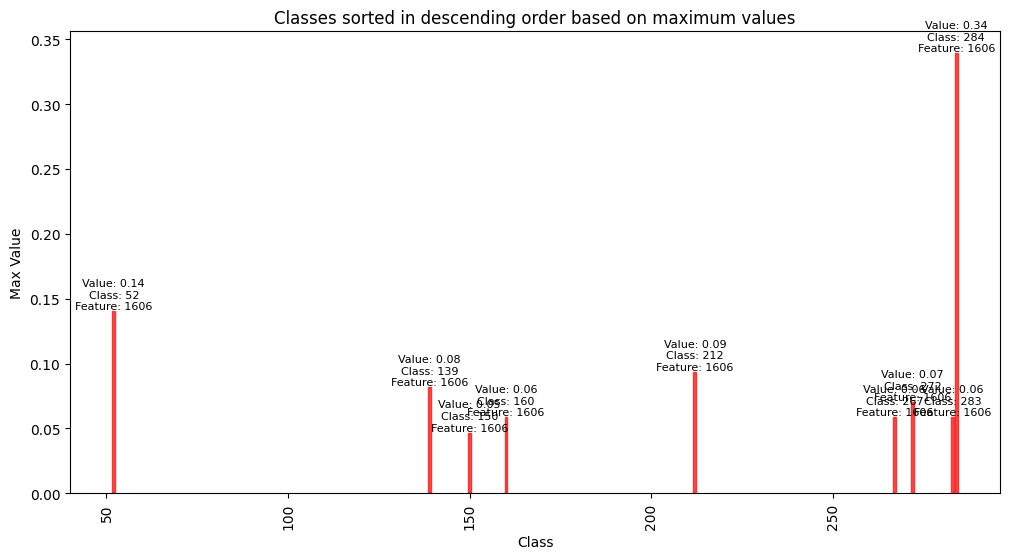

Classes sorted in descending order based on maximum values:
Class 284: Max value = 0.3391313340294602, Feature number = 1606
Class 52: Max value = 0.1403302071846042, Feature number = 1606
Class 212: Max value = 0.09355347145640282, Feature number = 1606
Class 139: Max value = 0.08185928752435245, Feature number = 1606
Class 272: Max value = 0.0701651035923021, Feature number = 1606
Class 160: Max value = 0.05847091966025176, Feature number = 1606
Class 267: Max value = 0.05847091966025176, Feature number = 1606
Class 283: Max value = 0.05847091966025176, Feature number = 1606
Class 150: Max value = 0.04677673572820141, Feature number = 1606


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming feature_importance is already defined
# feature_importance = ...

# Find the column numbers with strictly non-zero values
non_zero_columns = np.where(np.any(feature_importance_1 != 0, axis=0))[0]

# Dictionary to store the maximum value and its row number for each non-zero column
max_value_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance_1[:, col]
    
    # Find the maximum value and its row number
    max_value = np.max(column_values)
    max_row = np.argmax(column_values)
    
    # Store the maximum value and its row number in the dictionary
    if max_value != 0:
        max_value_per_column[col] = (max_value, max_row)

# Sort the columns in descending order based on the maximum values
sorted_columns = sorted(max_value_per_column.items(), key=lambda x: x[1][0], reverse=True)

# Extract the class values and corresponding feature values
classes = [col for col, _ in sorted_columns]
max_values = [max_value for _, (max_value, _) in sorted_columns]
feature_numbers = [max_row for _, (_, max_row) in sorted_columns]

# Plot the results
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, max_values, color='blue', alpha=0.7)

# Highlight the bars with non-zero values and annotate them with their values, class numbers, and feature numbers
for bar, max_value, class_num, feature_num in zip(bars, max_values, classes, feature_numbers):
    bar.set_color('red')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'Value: {max_value:.2f}\nClass: {class_num}\nFeature: {feature_num}', ha='center', va='bottom', color='black', fontsize=8)

plt.xlabel('Class')
plt.ylabel('Max Value')
plt.title('Classes sorted in descending order based on maximum values')
plt.xticks(rotation=90)
plt.show()

# Print the results
print("Classes sorted in descending order based on maximum values:")
for col, (max_value, max_row) in sorted_columns:
    print(f"Class {col}: Max value = {max_value}, Feature number = {max_row}")

In [14]:
# Usage example
sample_input_2 = X_test_dense[2]  # Pick one test instance
# example_index = 1 
feature_importance_2 = integrated_gradients_annexml(sample_input_2)



Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.93 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0242 sec, 24.1649 msec/sample (* 12 threads = 289.9790 msec/sample)
Partitioning: 0.0035 sec, Embedding: 0.0205 sec, Aggregating: 0.0001 sec
/tmp/ipykernel_5547/2613537384.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions_df = pd.concat([predictions_df, pd.DataFrame(pred_xi, columns=df_columns)], ignore_index=True)
Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, em

Step 1: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.75 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.4169 msec/sample (* 12 threads = 101.0027 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0052 sec, Aggregating: 0.0003 sec


Step 2: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.55 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.9410 msec/sample (* 12 threads = 95.2921 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0053 sec, Aggregating: 0.0001 sec


Step 3: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.72 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.3241 msec/sample (* 12 threads = 99.8898 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0057 sec, Aggregating: 0.0002 sec


Step 4: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.78 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4990 msec/sample (* 12 threads = 89.9878 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0049 sec, Aggregating: 0.0002 sec


Step 5: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.55 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0069 sec, 6.9079 msec/sample (* 12 threads = 82.8953 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0043 sec, Aggregating: 0.0004 sec


Step 6: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.83 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.9420 msec/sample (* 12 threads = 95.3035 msec/sample)
Partitioning: 0.0032 sec, Embedding: 0.0045 sec, Aggregating: 0.0003 sec


Step 7: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (13.97 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0721 msec/sample (* 12 threads = 96.8657 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0050 sec, Aggregating: 0.0004 sec


Step 8: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.73 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0065 sec, 6.4759 msec/sample (* 12 threads = 77.7111 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0036 sec, Aggregating: 0.0002 sec


Step 9: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.85 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0065 sec, 6.4819 msec/sample (* 12 threads = 77.7826 msec/sample)
Partitioning: 0.0017 sec, Embedding: 0.0042 sec, Aggregating: 0.0005 sec


Step 10: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.64 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0069 sec, 6.9361 msec/sample (* 12 threads = 83.2329 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0041 sec, Aggregating: 0.0005 sec


Step 11: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.76 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.3800 msec/sample (* 12 threads = 88.5601 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0043 sec, Aggregating: 0.0003 sec


Step 12: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.99 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.3099 msec/sample (* 12 threads = 87.7190 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0043 sec, Aggregating: 0.0003 sec


Step 13: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.05 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0769 msec/sample (* 12 threads = 96.9229 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0052 sec, Aggregating: 0.0001 sec


Step 14: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.10 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0073 sec, 7.2951 msec/sample (* 12 threads = 87.5416 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0045 sec, Aggregating: 0.0003 sec


Step 15: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.34 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0083 sec, 8.2829 msec/sample (* 12 threads = 99.3948 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0055 sec, Aggregating: 0.0004 sec


Step 16: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.92 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.1091 msec/sample (* 12 threads = 97.3091 msec/sample)
Partitioning: 0.0030 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 17: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.61 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0078 sec, 7.7598 msec/sample (* 12 threads = 93.1177 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0050 sec, Aggregating: 0.0004 sec


Step 18: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (14.49 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0081 sec, 8.0791 msec/sample (* 12 threads = 96.9486 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0052 sec, Aggregating: 0.0002 sec


Step 19: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.79 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0077 sec, 7.7240 msec/sample (* 12 threads = 92.6886 msec/sample)
Partitioning: 0.0031 sec, Embedding: 0.0044 sec, Aggregating: 0.0002 sec


Step 20: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.73 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.6230 msec/sample (* 12 threads = 91.4755 msec/sample)
Partitioning: 0.0021 sec, Embedding: 0.0053 sec, Aggregating: 0.0002 sec


Step 21: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.75 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.6029 msec/sample (* 12 threads = 91.2352 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0049 sec, Aggregating: 0.0001 sec


Step 22: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.86 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0071 sec, 7.0789 msec/sample (* 12 threads = 84.9466 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0043 sec, Aggregating: 0.0003 sec


Step 23: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.65 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0084 sec, 8.4119 msec/sample (* 12 threads = 100.9426 msec/sample)
Partitioning: 0.0032 sec, Embedding: 0.0050 sec, Aggregating: 0.0002 sec


Step 24: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.68 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.3719 msec/sample (* 12 threads = 88.4628 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 25: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.83 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.5409 msec/sample (* 12 threads = 90.4913 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 26: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.72 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4742 msec/sample (* 12 threads = 89.6902 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0047 sec, Aggregating: 0.0002 sec


Step 27: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.77 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0082 sec, 8.1670 msec/sample (* 12 threads = 98.0043 msec/sample)
Partitioning: 0.0030 sec, Embedding: 0.0049 sec, Aggregating: 0.0002 sec


Step 28: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.70 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0071 sec, 7.1290 msec/sample (* 12 threads = 85.5474 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0045 sec, Aggregating: 0.0003 sec


Step 29: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.00 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0078 sec, 7.8392 msec/sample (* 12 threads = 94.0704 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0047 sec, Aggregating: 0.0005 sec


Step 30: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.80 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.4470 msec/sample (* 12 threads = 89.3641 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0046 sec, Aggregating: 0.0003 sec


Step 31: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.77 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0080 sec, 8.0380 msec/sample (* 12 threads = 96.4565 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0054 sec, Aggregating: 0.0002 sec


Step 32: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.80 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0074 sec, 7.3760 msec/sample (* 12 threads = 88.5115 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0043 sec, Aggregating: 0.0003 sec


Step 33: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.68 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0079 sec, 7.9019 msec/sample (* 12 threads = 94.8229 msec/sample)
Partitioning: 0.0029 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 34: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.53 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.5240 msec/sample (* 12 threads = 90.2882 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0045 sec, Aggregating: 0.0004 sec


Step 35: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.75 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0088 sec, 8.7938 msec/sample (* 12 threads = 105.5260 msec/sample)
Partitioning: 0.0036 sec, Embedding: 0.0047 sec, Aggregating: 0.0005 sec


Step 36: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.89 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.5800 msec/sample (* 12 threads = 90.9605 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0047 sec, Aggregating: 0.0003 sec


Step 37: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.68 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0071 sec, 7.0910 msec/sample (* 12 threads = 85.0925 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0042 sec, Aggregating: 0.0005 sec


Step 38: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.76 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0078 sec, 7.8230 msec/sample (* 12 threads = 93.8759 msec/sample)
Partitioning: 0.0022 sec, Embedding: 0.0054 sec, Aggregating: 0.0002 sec


Step 39: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.87 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0076 sec, 7.6480 msec/sample (* 12 threads = 91.7759 msec/sample)
Partitioning: 0.0024 sec, Embedding: 0.0051 sec, Aggregating: 0.0002 sec


Step 40: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (15.77 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0077 sec, 7.7310 msec/sample (* 12 threads = 92.7715 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0050 sec, Aggregating: 0.0001 sec


Step 41: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.02 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0071 sec, 7.1251 msec/sample (* 12 threads = 85.5017 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0042 sec, Aggregating: 0.0002 sec


Step 42: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.11 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0075 sec, 7.4902 msec/sample (* 12 threads = 89.8819 msec/sample)
Partitioning: 0.0025 sec, Embedding: 0.0048 sec, Aggregating: 0.0002 sec


Step 43: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.21 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0102 sec, 10.1662 msec/sample (* 12 threads = 121.9940 msec/sample)
Partitioning: 0.0038 sec, Embedding: 0.0062 sec, Aggregating: 0.0002 sec


Step 44: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.17 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0068 sec, 6.7890 msec/sample (* 12 threads = 81.4676 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0039 sec, Aggregating: 0.0003 sec


Step 45: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (17.10 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0088 sec, 8.7700 msec/sample (* 12 threads = 105.2399 msec/sample)
Partitioning: 0.0027 sec, Embedding: 0.0058 sec, Aggregating: 0.0003 sec


Step 46: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.68 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0085 sec, 8.4989 msec/sample (* 12 threads = 101.9869 msec/sample)
Partitioning: 0.0028 sec, Embedding: 0.0053 sec, Aggregating: 0.0003 sec


Step 47: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex done! (16.76 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0062 sec, 6.2158 msec/sample (* 12 threads = 74.5897 msec/sample)
Partitioning: 0.0023 sec, Embedding: 0.0037 sec, Aggregating: 0.0002 sec


Step 48: Nonzero attributions count = 38912


Loaded model from AnnexML/iaprtc12_model.bin
Total: 114.37 MB => labels: 0.55 MB, partitioning: 0.49 MB, embedding: 113.33 MB (matrix: 21.47 MB, embed: 90.44 MB) 
num_edge: 10, search_eps: 0.500000
Build SearchIndex...

Step 49: Nonzero attributions count = 38912


Build SearchIndex done! (16.17 sec, 23.33 MB)
Load Predict Data: #data=1 #feature=2048 #label=0
Done!
Elapsed: 0.0078 sec, 7.8309 msec/sample (* 12 threads = 93.9703 msec/sample)
Partitioning: 0.0026 sec, Embedding: 0.0050 sec, Aggregating: 0.0002 sec


In [17]:
# Find the column numbers with non-zero values
non_zero_columns = np.where(np.any(feature_importance_2 != 0, axis=0))[0]

# Dictionary to store the top three rows for each non-zero column
top_three_rows_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance_2[:, col]
    
    # Get the indices of the top three values
    top_three_indices = np.argsort(column_values)[-3:][::-1]
    
    # Store the top three rows in the dictionary
    top_three_rows_per_column[col] = top_three_indices

# Print the results
for col, rows in top_three_rows_per_column.items():
    print(f"Column {col} top three rows with highest values: {rows}")

Column 13 top three rows with highest values: [1539 1537 1536]
Column 39 top three rows with highest values: [1117 1606 1222]
Column 52 top three rows with highest values: [1117 1606 1222]
Column 56 top three rows with highest values: [1117 1606 1222]
Column 89 top three rows with highest values: [1539 1537 1536]
Column 117 top three rows with highest values: [1539 1537 1536]
Column 130 top three rows with highest values: [1539 1537 1536]
Column 139 top three rows with highest values: [1117 1606 1222]
Column 144 top three rows with highest values: [1539 1537 1536]
Column 160 top three rows with highest values: [1117 1606 1222]
Column 162 top three rows with highest values: [1539 1537 1536]
Column 179 top three rows with highest values: [1539 1537 1536]
Column 210 top three rows with highest values: [1117 1606 1222]
Column 232 top three rows with highest values: [1117 1606 1222]
Column 236 top three rows with highest values: [1539 1537 1536]
Column 257 top three rows with highest values

In [18]:
# Assuming feature_importance is already defined
# feature_importance = ...

# Find the column numbers with non-zero values
non_zero_columns = np.where(np.any(feature_importance_2 != 0, axis=0))[0]

# Dictionary to store the maximum value and its row number for each non-zero column
max_value_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance_2[:, col]
    
    # Find the maximum value and its row number
    max_value = np.max(column_values)
    max_row = np.argmax(column_values)
    
    # Store the maximum value and its row number in the dictionary
    max_value_per_column[col] = (max_value, max_row)

# Sort the columns in descending order based on the maximum values
sorted_columns = sorted(max_value_per_column.items(), key=lambda x: x[1][0], reverse=True)

# Print the results
print("Classes sorted in descending order based on maximum values:")
for col, (max_value, max_row) in sorted_columns:
    print(f"Class {col}: Max value = {max_value}, Feature number = {max_row}")

Classes sorted in descending order based on maximum values:
Class 284: Max value = 0.23549713593264301, Feature number = 1117
Class 56: Max value = 0.09594327760218789, Feature number = 1117
Class 210: Max value = 0.09594327760218789, Feature number = 1117
Class 52: Max value = 0.08722116145653444, Feature number = 1117
Class 139: Max value = 0.08722116145653444, Feature number = 1117
Class 160: Max value = 0.08722116145653444, Feature number = 1117
Class 39: Max value = 0.07849904531088099, Feature number = 1117
Class 232: Max value = 0.07849904531088099, Feature number = 1117
Class 272: Max value = 0.06977692916522754, Feature number = 1117
Class 13: Max value = -0.0, Feature number = 1
Class 89: Max value = -0.0, Feature number = 1
Class 117: Max value = -0.0, Feature number = 1
Class 130: Max value = -0.0, Feature number = 1
Class 144: Max value = -0.0, Feature number = 1
Class 162: Max value = -0.0, Feature number = 1
Class 179: Max value = -0.0, Feature number = 1
Class 236: Max 

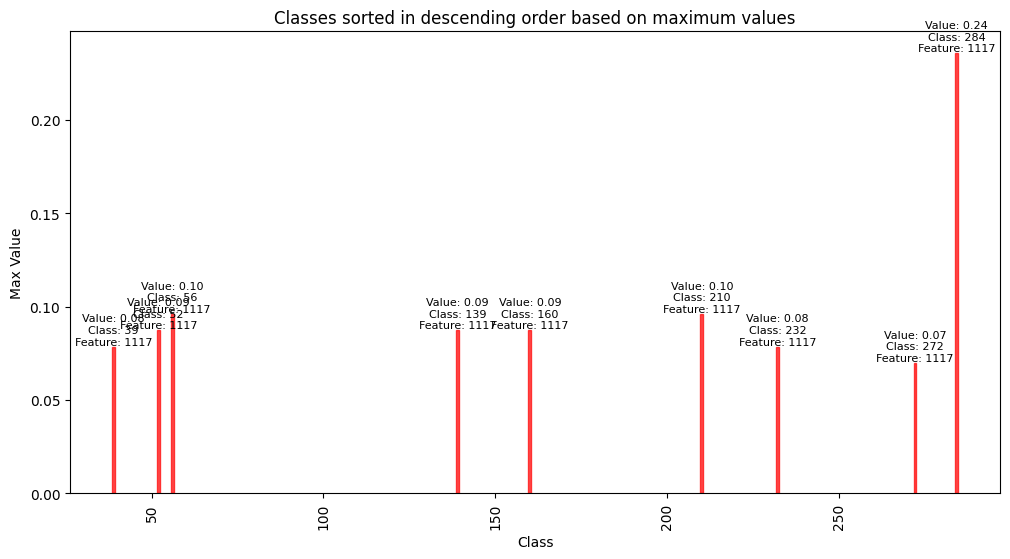

Classes sorted in descending order based on maximum values:
Class 284: Max value = 0.23549713593264301, Feature number = 1117
Class 56: Max value = 0.09594327760218789, Feature number = 1117
Class 210: Max value = 0.09594327760218789, Feature number = 1117
Class 52: Max value = 0.08722116145653444, Feature number = 1117
Class 139: Max value = 0.08722116145653444, Feature number = 1117
Class 160: Max value = 0.08722116145653444, Feature number = 1117
Class 39: Max value = 0.07849904531088099, Feature number = 1117
Class 232: Max value = 0.07849904531088099, Feature number = 1117
Class 272: Max value = 0.06977692916522754, Feature number = 1117


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming feature_importance is already defined
# feature_importance = ...

# Find the column numbers with strictly non-zero values
non_zero_columns = np.where(np.any(feature_importance_2 != 0, axis=0))[0]

# Dictionary to store the maximum value and its row number for each non-zero column
max_value_per_column = {}

for col in non_zero_columns:
    # Get the values in the column
    column_values = feature_importance_2[:, col]
    
    # Find the maximum value and its row number
    max_value = np.max(column_values)
    max_row = np.argmax(column_values)
    
    # Store the maximum value and its row number in the dictionary
    if max_value != 0:
        max_value_per_column[col] = (max_value, max_row)

# Sort the columns in descending order based on the maximum values
sorted_columns = sorted(max_value_per_column.items(), key=lambda x: x[1][0], reverse=True)

# Extract the class values and corresponding feature values
classes = [col for col, _ in sorted_columns]
max_values = [max_value for _, (max_value, _) in sorted_columns]
feature_numbers = [max_row for _, (_, max_row) in sorted_columns]

# Plot the results
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, max_values, color='blue', alpha=0.7)

# Highlight the bars with non-zero values and annotate them with their values, class numbers, and feature numbers
for bar, max_value, class_num, feature_num in zip(bars, max_values, classes, feature_numbers):
    bar.set_color('red')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'Value: {max_value:.2f}\nClass: {class_num}\nFeature: {feature_num}', ha='center', va='bottom', color='black', fontsize=8)

plt.xlabel('Class')
plt.ylabel('Max Value')
plt.title('Classes sorted in descending order based on maximum values')
plt.xticks(rotation=90)
plt.show()

# Print the results
print("Classes sorted in descending order based on maximum values:")
for col, (max_value, max_row) in sorted_columns:
    print(f"Class {col}: Max value = {max_value}, Feature number = {max_row}")